# General Data Analysis

In [1]:
# Import libaries
import numpy as np 
import pandas as pd 
import seaborn as sns; sns.set(rc={'figure.figsize':(16,9)})
import matplotlib.pyplot as plt
from scipy import stats 

In [2]:
# Read the datasets
olist_customers = pd.read_csv('olist_customers_dataset.csv')
olist_geolocation = pd.read_csv('olist_geolocation_dataset.csv')
olist_orders = pd.read_csv('olist_orders_dataset.csv')
olist_items = pd.read_csv('olist_order_items_dataset.csv')
olist_order_payments = pd.read_csv('olist_order_payments_dataset.csv')
olist_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
olist_products = pd.read_csv('olist_products_dataset.csv')
olist_sellers = pd.read_csv('olist_sellers_dataset.csv')
olist_category = pd.read_csv('product_category_name_translation.csv')

In [3]:
# Merge the datasets
olist_new = olist_orders.merge(olist_items, on='order_id', how='left')
olist_new = olist_new.merge(olist_order_payments, on='order_id', how='outer', validate='m:m')
olist_new = olist_new.merge(olist_reviews, on='order_id', how='outer')
olist_new = olist_new.merge(olist_products, on='product_id', how='outer')
olist_new = olist_new.merge(olist_customers, on='customer_id', how='outer')
olist_new = olist_new.merge(olist_sellers, on='seller_id', how='outer')
olist_new= olist_new.merge(olist_category, on='product_category_name', how='inner')

olist_new.shape

(116576, 40)

**Data Cleaning**



In [5]:
# Drop missing datetime related values
olist_new.dropna(subset= ['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date'], inplace=True)

In [7]:
def classify_cat(x):

    if x in ['office_furniture', 'furniture_decor', 'furniture_living_room', 'kitchen_dining_laundry_garden_furniture', 'bed_bath_table', 'home_comfort', 'home_comfort_2', 'home_construction', 'garden_tools', 'furniture_bedroom', 'furniture_mattress_and_upholstery']:
        return 'Furniture'
    
    elif x in ['auto', 'computers_accessories', 'musical_instruments', 'consoles_games', 'watches_gifts', 'air_conditioning', 'telephony', 'electronics', 'fixed_telephony', 'tablets_printing_image', 'computers', 'small_appliances_home_oven_and_coffee', 'small_appliances', 'audio', 'signaling_and_security', 'security_and_services']:
        return 'Electronics'
    
    elif x in ['fashio_female_clothing', 'fashion_male_clothing', 'fashion_bags_accessories', 'fashion_shoes', 'fashion_sport', 'fashion_underwear_beach', 'fashion_childrens_clothes', 'baby', 'cool_stuff', ]:
        return 'Fashion'
    
    elif x in ['housewares', 'home_confort', 'home_appliances', 'home_appliances_2', 'flowers', 'costruction_tools_garden', 'garden_tools', 'construction_tools_lights', 'costruction_tools_tools', 'luggage_accessories', 'la_cuisine', 'pet_shop', 'market_place']:
        return 'Home & Garden'
    
    elif x in ['sports_leisure', 'toys', 'cds_dvds_musicals', 'music', 'dvds_blu_ray', 'cine_photo', 'party_supplies', 'christmas_supplies', 'arts_and_craftmanship', 'art']:
        return 'Entertainment'
    
    elif x in ['health_beauty', 'perfumery', 'diapers_and_hygiene']:
        return 'Beauty & Health'
    
    elif x in ['food_drink', 'drinks', 'food']:
        return 'Food & Drinks'
    
    elif x in ['books_general_interest', 'books_technical', 'books_imported', 'stationery']:
        return 'Books & Stationery'
    
    elif x in ['construction_tools_construction', 'construction_tools_safety', 'industry_commerce_and_business', 'agro_industry_and_commerce']:
        return 'Industry & Construction'

olist_new['product_category'] = olist_new.product_category_name_english.apply(classify_cat)

In [8]:
# Datetime features from Object to Datetime
olist_new['order_purchase_timestamp'] = pd.to_datetime(olist_new['order_purchase_timestamp'])
olist_new['order_delivered_customer_date'] = pd.to_datetime(olist_new['order_delivered_customer_date'])
olist_new['order_estimated_delivery_date'] = pd.to_datetime(olist_new['order_estimated_delivery_date'])
olist_new['shipping_limit_date'] = pd.to_datetime(olist_new['shipping_limit_date'])
olist_new['order_delivered_carrier_date'] =pd.to_datetime(olist_new['order_delivered_carrier_date'])

In [9]:
# Extract duration of estimated shipping from purchasing date untill estimated delivery date
# Extract duration of shipping from purchasing date until delivered to customer date
# Extract duration of shipping from purchasing carrier delivered date untill delivered to customer
# Drop inconsistent dates where "order_delivered_carrier_date" is greater than "order_delivered_customer_date"
olist_new['estimated_days'] = (olist_new['order_estimated_delivery_date'].dt.date - olist_new['order_purchase_timestamp'].dt.date).dt.days
olist_new['arrival_days'] = (olist_new['order_delivered_customer_date'].dt.date - olist_new['order_purchase_timestamp'].dt.date).dt.days
olist_new['shipping_days'] = (olist_new['order_delivered_customer_date'].dt.date - olist_new['order_delivered_carrier_date'].dt.date).dt.days
olist_new.drop((olist_new[['order_delivered_carrier_date', 'order_delivered_customer_date']][olist_new.shipping_days < 0]).index, inplace= True)

In [10]:
# Shipping status from Seller to Carrier
# First get seller to carrier duration in days
olist_new['seller_to_carrier_status'] = (olist_new['shipping_limit_date'].dt.date - olist_new['order_delivered_carrier_date'].dt.date).dt.days

# Now calssify the duration into 'OnTime/Early' & 'Late'
olist_new['seller_to_carrier_status'] = olist_new['seller_to_carrier_status'].apply(lambda x : 'OnTime/Early' if x >=0 else 'Late')

In [11]:
# Shipping status from Carrier to Customer
# First get difference between estimated delivery date and actual delivery date in days
olist_new['arrival_status'] = (olist_new['order_estimated_delivery_date'].dt.date - olist_new['order_delivered_customer_date'].dt.date).dt.days

# Now Classify the duration in 'OnTime/Early' & 'Late'
olist_new['arrival_status'] = olist_new['arrival_status'].apply(lambda x : 'OnTime/Early' if x >=0 else 'Late')

In [12]:
olist_new[['estimated_days', 'arrival_days', 'shipping_days']].describe()

,estimated_days,arrival_days,shipping_days
count,113993.000000,113993.00000,113993.000000
mean,24.476599,12.42714,9.163545
std,8.826484,9.45142,8.647804
min,3.000000,0.00000,0.000000
25%,19.000000,7.00000,4.000000
50%,24.000000,10.00000,7.000000
75%,29.000000,16.00000,12.000000
max,156.000000,210.00000,205.000000


In [13]:
# Remove Outliers in both features ( More than 60 days 
outlier_indices = olist_new[(olist_new.estimated_days > 60) | (olist_new.arrival_days > 60) | (olist_new.shipping_days > 60)].index

olist_new.drop(outlier_indices, inplace= True)
olist_new.reset_index(inplace= True, drop= True)

In [14]:
# Rating estimated delivery time
def rates(x):

    if x in range(0, 8):
        return 'Very Fast'
    
    elif x in range(8, 16):
        return 'Fast'
    
    elif x in range(16, 25):
        return 'Neutral'
    
    elif x in range(25, 40):
        return 'Slow'
    
    else:
        return 'Very Slow'

olist_new['estimated_delivery_rate'] = olist_new.estimated_days.apply(rates)

olist_new['arrival_delivery_rate'] = olist_new.arrival_days.apply(rates)

olist_new['shipping_delivery_rate'] = olist_new.shipping_days.apply(rates)

In [15]:
# Time-Stamps transition --> Converting Datetime from Object to Datetime
olist_new['purchase_year'] = olist_new['order_purchase_timestamp'].dt.year
olist_new['purchase_month'] = olist_new['order_purchase_timestamp'].dt.month
olist_new['purchase_day'] = olist_new['order_purchase_timestamp'].dt.day
olist_new['purchase_day_of_week'] = olist_new['order_purchase_timestamp'].dt.dayofweek
olist_new['purchase_hour'] = olist_new['order_purchase_timestamp'].dt.hour

In [16]:
# Converting orders to date
orders_per_year = olist_new['purchase_year'].value_counts().sort_index()

orders_per_month = olist_new.groupby('purchase_month').size()

orders_per_day_of_week = olist_new['purchase_day_of_week'].value_counts().sort_index()

orders_per_hour = olist_new['purchase_hour'].value_counts().sort_index()

**Exploratory Data Analysis**

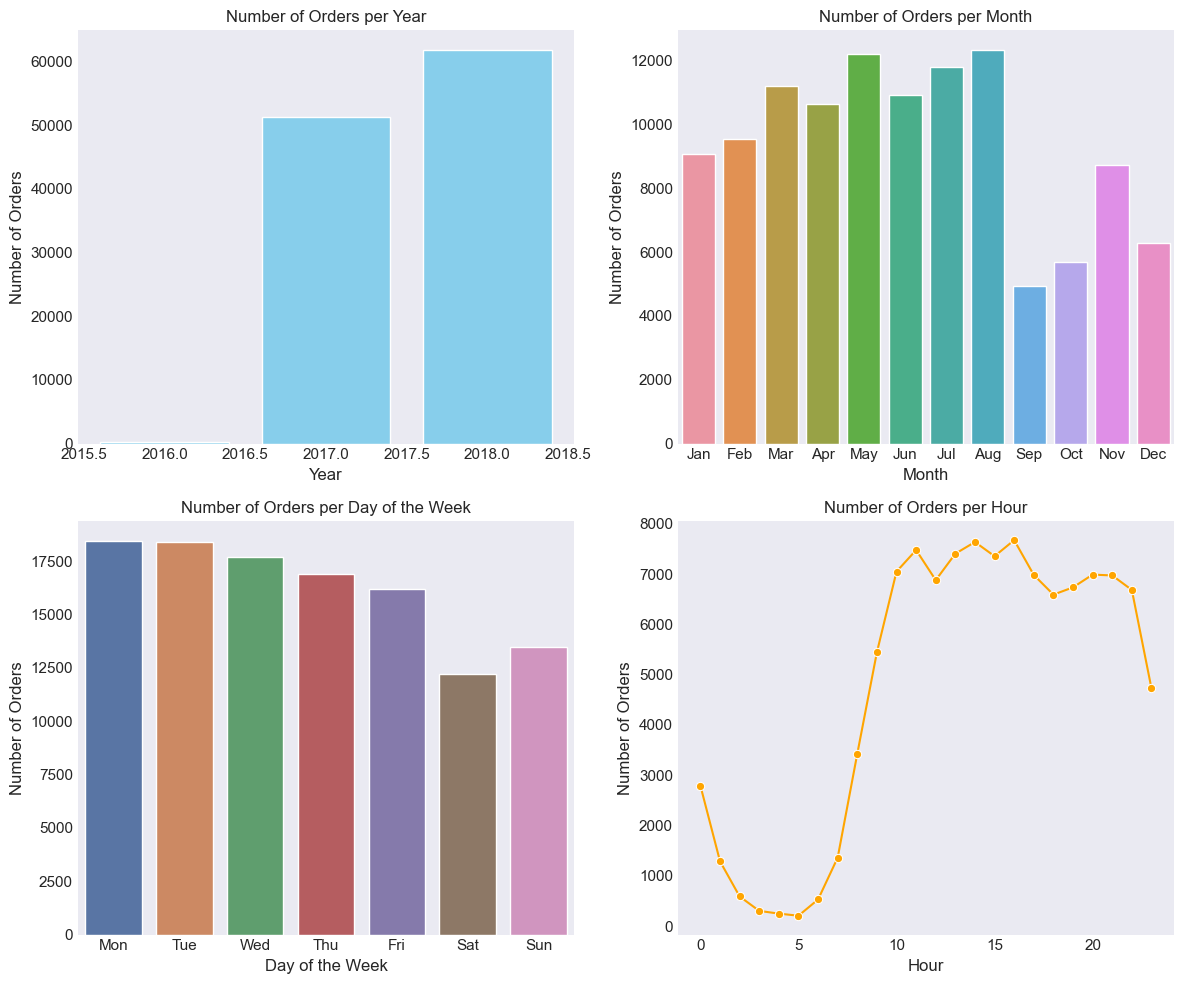

In [19]:
# Create subplots for each graph
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot number of orders per year
axes[0, 0].bar(orders_per_year.index, orders_per_year.values, color='skyblue')
axes[0, 0].set_title('Number of Orders per Year')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Number of Orders')

# Plot number of orders per month with month names
sns.barplot(x=orders_per_month.index.map({1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}),
            y=orders_per_month.values, ax=axes[0, 1])
axes[0, 1].set_title('Number of Orders per Month')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Number of Orders')

# Plot number of orders per day of the week with day names
sns.barplot(x=orders_per_day_of_week.index.map({0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}),
            y=orders_per_day_of_week.values, ax=axes[1, 0])
axes[1, 0].set_title('Number of Orders per Day of the Week')
axes[1, 0].set_xlabel('Day of the Week')
axes[1, 0].set_ylabel('Number of Orders')

# Plot number of orders per hour
sns.lineplot(x=orders_per_hour.index, y=orders_per_hour.values, ax=axes[1, 1], marker='o', color='orange')
axes[1, 1].set_title('Number of Orders per Hour')
axes[1, 1].set_xlabel('Hour')
axes[1, 1].set_ylabel('Number of Orders')

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()

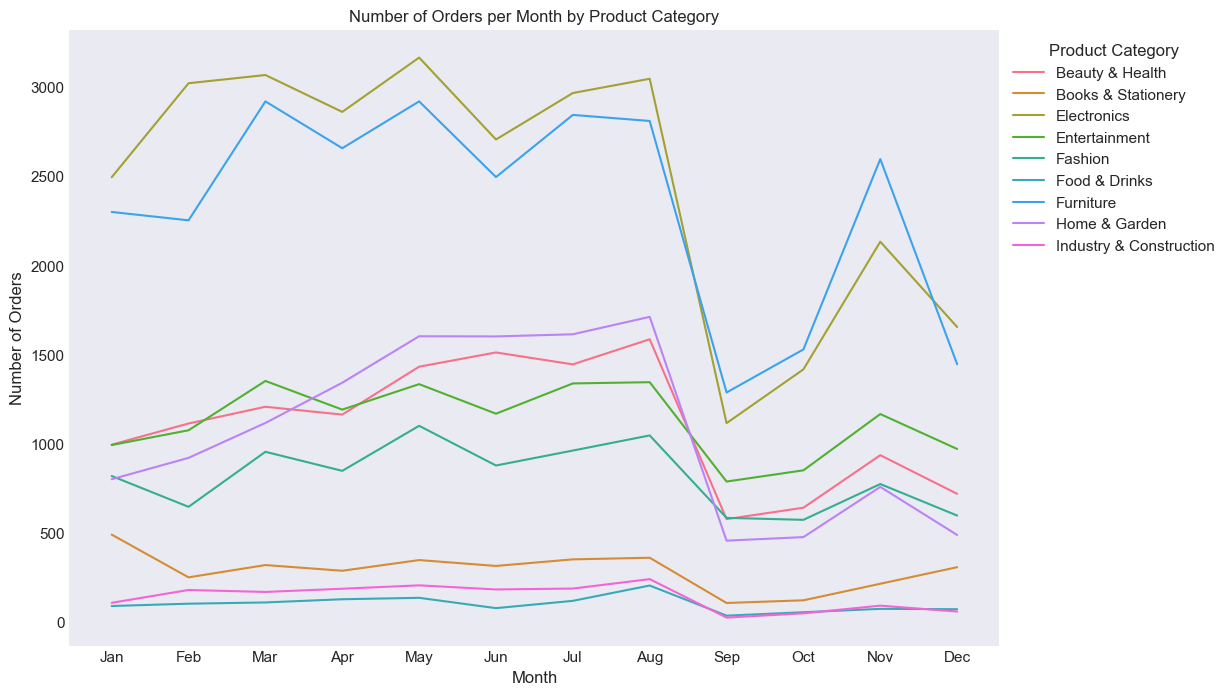

In [45]:
# Group orders by month and product category and calculate the count
orders_per_month_category = olist_new.groupby(['purchase_month', 'product_category']).size().reset_index(name='order_count')
plt.figure(figsize=[12,8])
# Plot number of orders per month with month names and product category
sns.lineplot(x=orders_per_month_category['purchase_month'].map({1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}),
             y=orders_per_month_category['order_count'], hue=orders_per_month_category['product_category'])
plt.title('Number of Orders per Month by Product Category')
plt.xlabel('Month')
plt.ylabel('Number of Orders')

# Show legend outside the plot
plt.legend(title='Product Category', loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

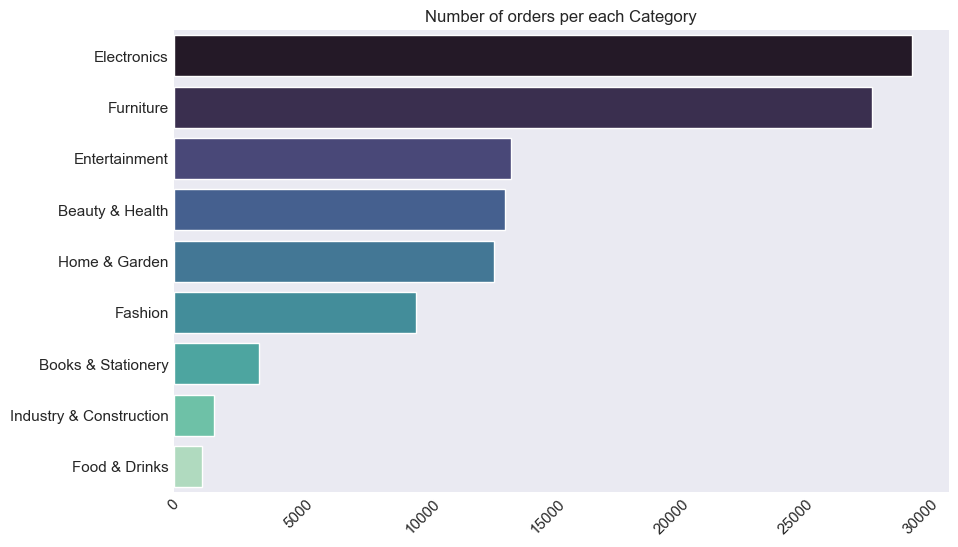

In [22]:
# Number of orders per category
plt.figure(figsize=[10, 6])
sns.barplot(x = olist_new.product_category.value_counts().values, y = olist_new.product_category.value_counts().index, palette= "mako")
plt.title('Number of orders per each Category')
plt.xticks(rotation = 45)
sns.despine()

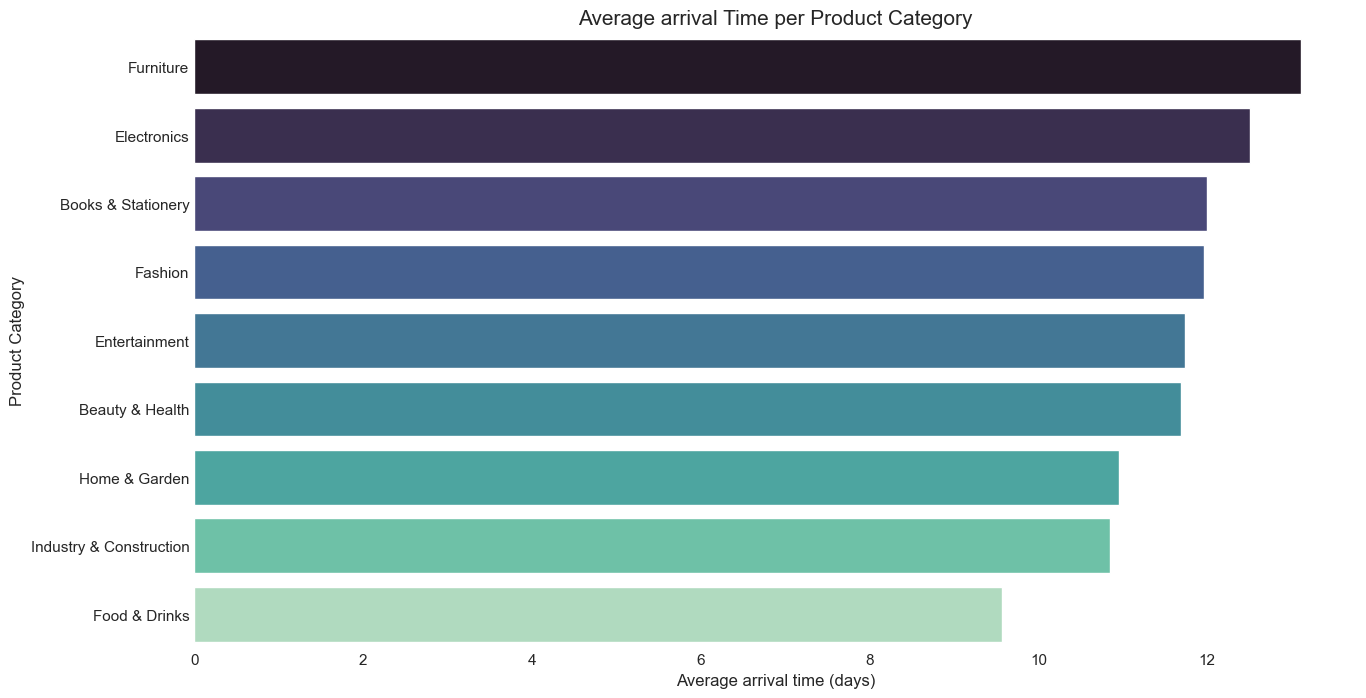

In [24]:
# Average shipping time per product category

# Group product category by average arrival time
ship_per_cat = olist_new.groupby('product_category')[['arrival_days']].mean().sort_values(by='arrival_days', ascending=False)
ship_per_cat.reset_index(inplace=True)

# plot average freight value per product category
plt.figure(figsize=[15, 8])
sns.barplot(x = ship_per_cat.arrival_days, y=  ship_per_cat.product_category, palette= "mako")
plt.title('Average arrival Time per Product Category', fontsize= 15)
plt.xlabel('Average arrival time (days)',fontsize= 12)
plt.ylabel('Product Category', fontsize= 12)
ax = plt.gca()
ax.set_frame_on(False);

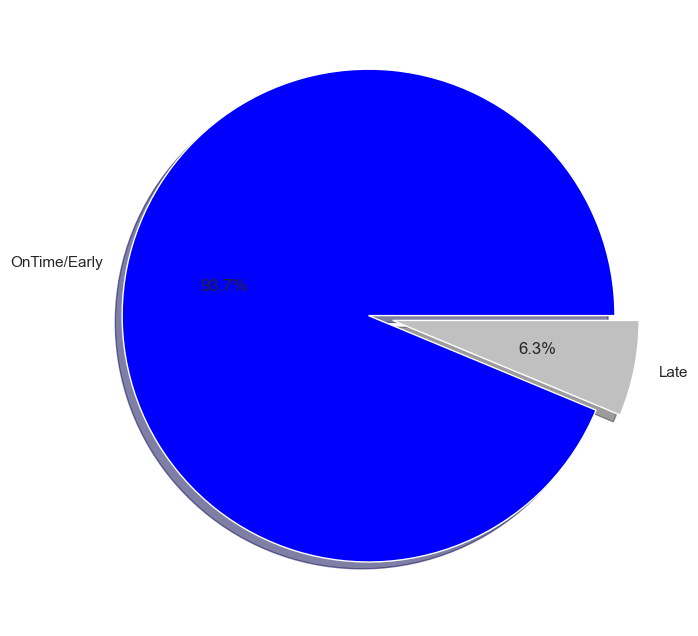

In [25]:
# How accurate are the estimated delivery dates to customers

plt.figure(figsize=[30,8])
Values = olist_new.arrival_status.value_counts().values
Labels = olist_new.arrival_status.value_counts().index
plt.pie(Values, explode=(0.05, 0.05), labels= ['OnTime/Early', 'Late'], autopct='%1.1f%%', shadow=True, colors= ('#0000FF', '#C0C0C0'));

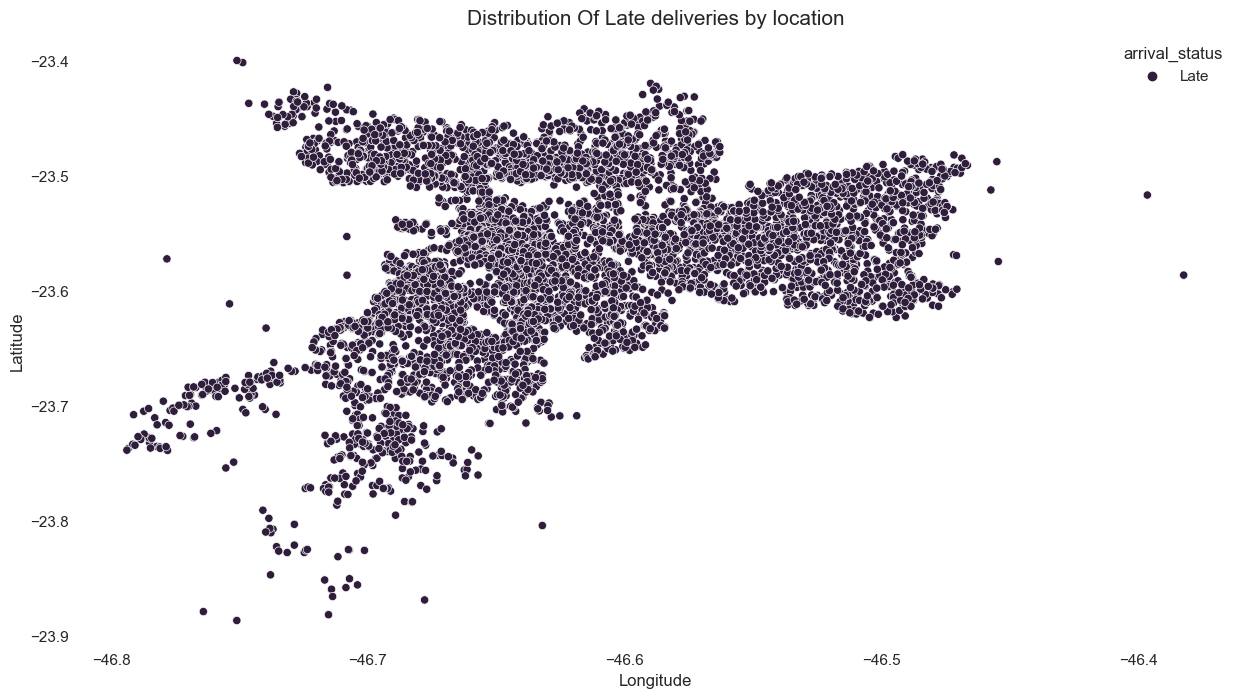

In [47]:
# Delays per location

late_deliveries = olist_new[olist_new['arrival_status'] == 'Late']

plt.figure(figsize=[15, 8])
sns.scatterplot(x = olist_geolocation.geolocation_lng, y = olist_geolocation.geolocation_lat, hue= late_deliveries.arrival_status)
plt.title('Distribution Of Late deliveries by location', fontsize= 15)
plt.xlabel('Longitude',fontsize= 12)
plt.ylabel('Latitude', fontsize= 12)
ax = plt.gca()
ax.set_frame_on(False);sns.despine()

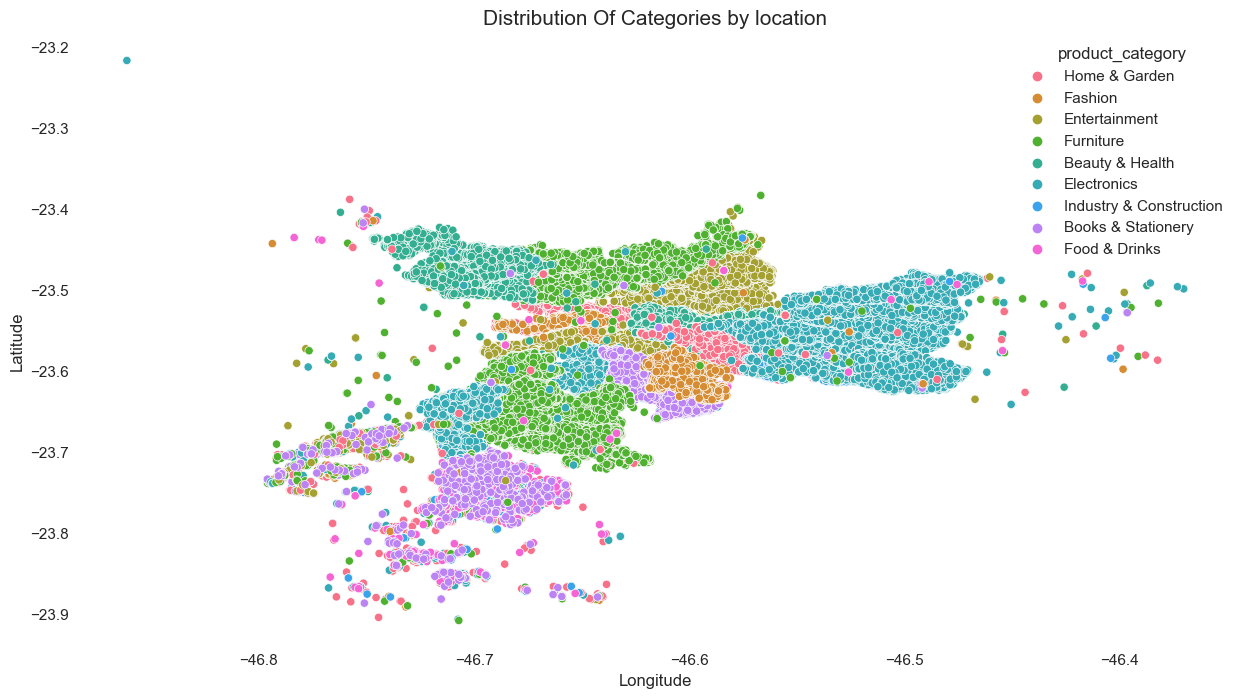

In [29]:
# Product categories per location
plt.figure(figsize=[15, 8])
sns.scatterplot(x = olist_geolocation.geolocation_lng, y = olist_geolocation.geolocation_lat, hue= olist_new.product_category)
plt.title('Distribution Of Categories by location', fontsize= 15)
plt.xlabel('Longitude',fontsize= 12)
plt.ylabel('Latitude', fontsize= 12)
ax = plt.gca()
ax.set_frame_on(False);sns.despine()

C:\Users\daant\AppData\Local\Temp\ipykernel_12900\35028348.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x = olist_new.price)


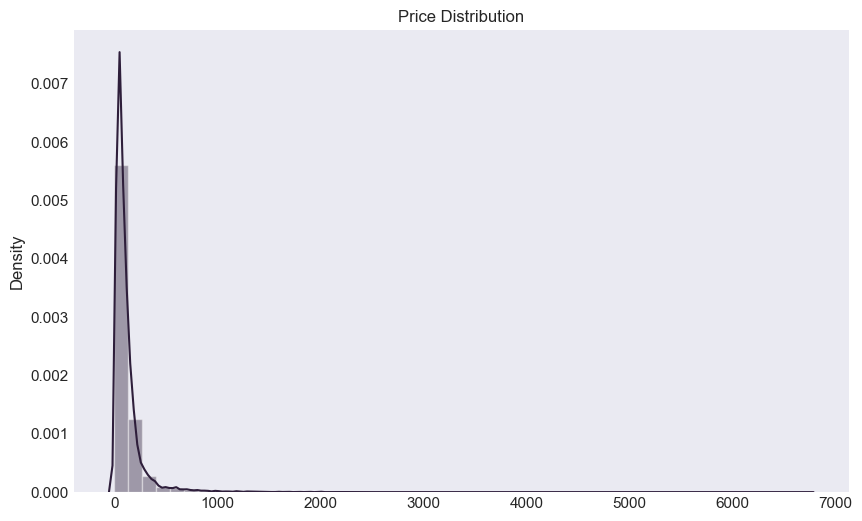

In [28]:
plt.figure(figsize=[10, 6])
sns.set_palette("mako")
sns.distplot(x = olist_new.price)
plt.title('Price Distribution')
sns.despine()

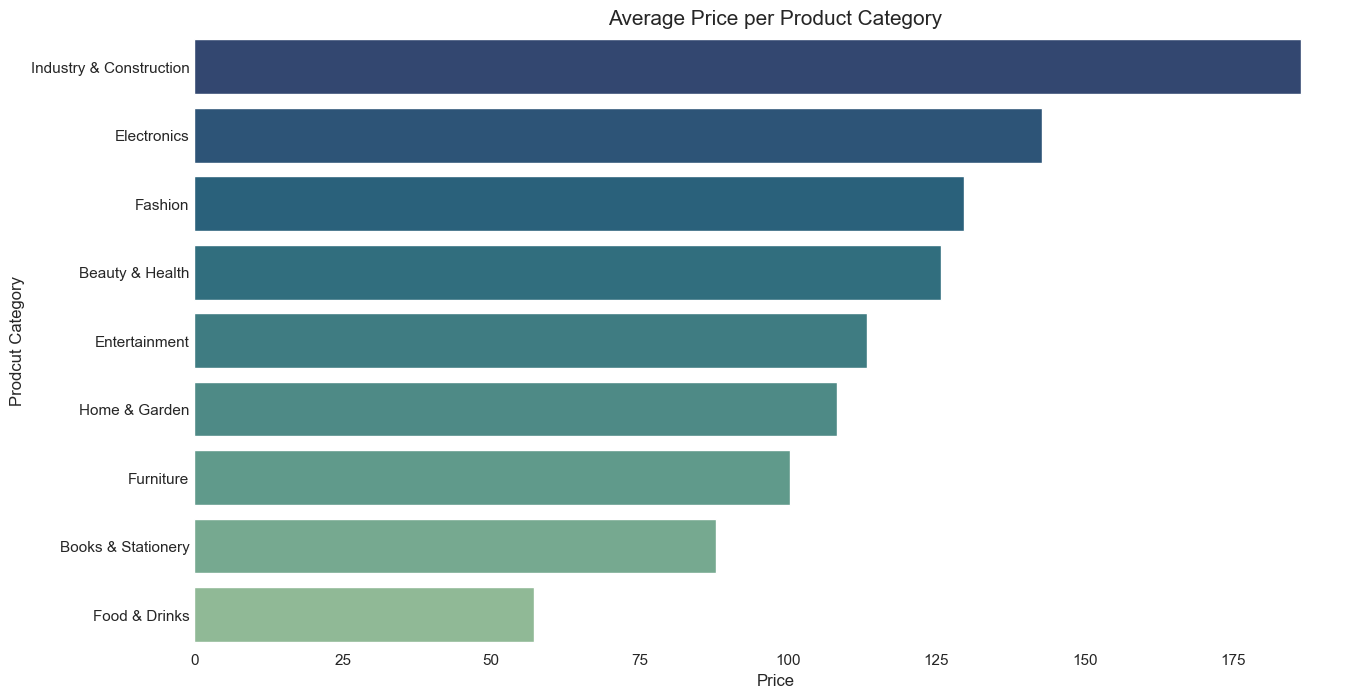

In [37]:

price_per_cat = olist_new.groupby('product_category')[['price']].mean().sort_values(by='price', ascending=False)
price_per_cat.reset_index(inplace=True)

# Plot Product Category vs Price
plt.figure(figsize=[15, 8])
sns.barplot(x = price_per_cat.price, y= price_per_cat.product_category, palette= 'crest_r')
plt.title('Average Price per Product Category', fontsize= 15)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Prodcut Category', fontsize= 12)
ax = plt.gca()
ax.set_frame_on(False);

KeyError: 'geolocation_lng'

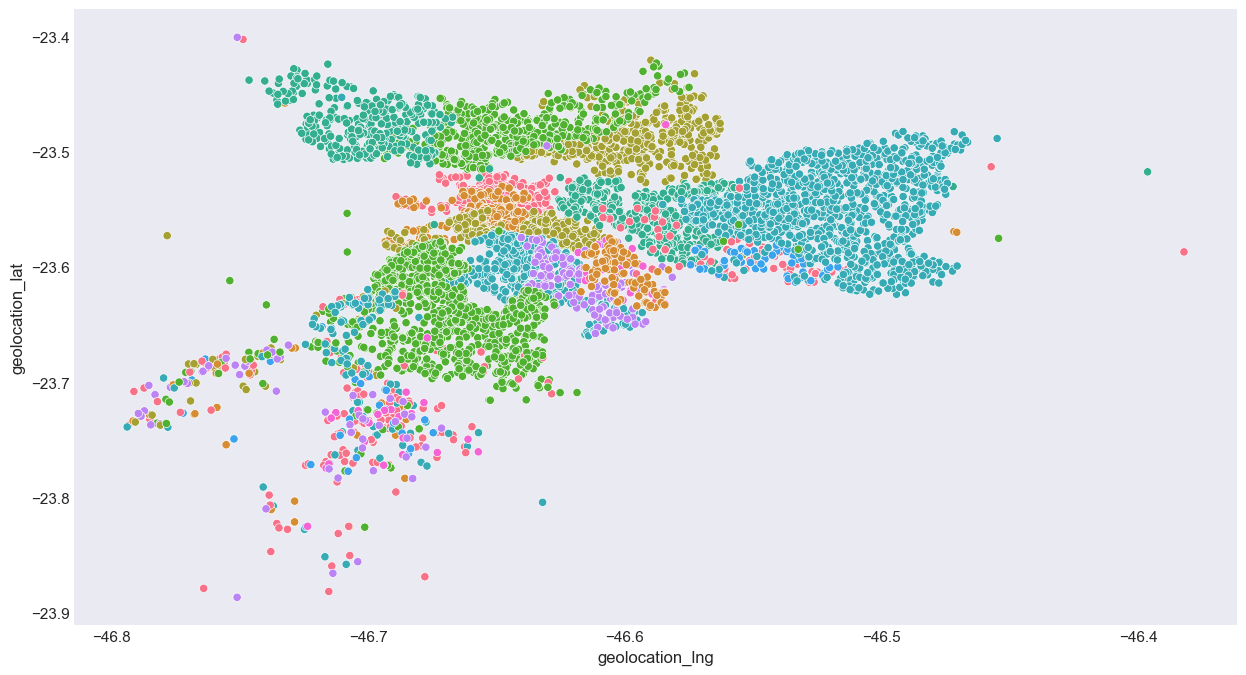

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'product_category' is a column in your DataFrame
# Filter late deliveries by product category
late_deliveries = olist_new[olist_new['arrival_status'] == 'Late']

plt.figure(figsize=[15, 8])

# Scatterplot for late deliveries
sns.scatterplot(x=olist_geolocation.geolocation_lng, y=olist_geolocation.geolocation_lat, hue=late_deliveries['product_category'], legend=False)

# Connect late deliveries by product category
for category in late_deliveries['product_category'].unique():
    category_data = late_deliveries[late_deliveries['product_category'] == category]
    plt.plot(category_data['geolocation_lng'], category_data['geolocation_lat'], marker='o', label=category)

plt.title('Distribution of Late Deliveries by Location and Product Category', fontsize=15)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.legend(title='Product Category', loc='upper left', bbox_to_anchor=(1, 1))
ax = plt.gca()
ax.set_frame_on(False)
sns.despine()

plt.show()


In [ ]:
copy_olist = olist_new.copy()